In [1]:
from sklearn.datasets import fetch_olivetti_faces
import numpy as np
import matplotlib.pyplot as plt

In [2]:
class FisherLDA:
    dataset = []
    samples = []
    labels = []
    classes = []

    m = None
    n = None

    sb = sw = None

    samples_by_class = None
    samples_mean = None
    samples_mean_class_wise = None
    sample_centered = None
    scatter_within = None
    scatter_between = None
    eigen_vectors = None
    eigen_values = None
    means = None

    transformed_samples = []
    reconstructed_samples = []

    def __init__(self, dataset_name = "olivetti"):
        if(dataset_name == "olivetti"):
            self.load_olivetti()
        else:
            raise Exception("Sorry, we don't support that yet, maybe later :)")
        
    def load_olivetti(self):
        rng = np.random.RandomState(0)
        self.dataset = fetch_olivetti_faces(shuffle=True, random_state=rng)
        self.samples = self.dataset.images
        self.labels = self.dataset.target
        classes = np.unique(self.labels)
        classes.sort()

        self.samples_by_class = [[self.samples[self.labels == cls] for cls in classes] for cls in classes]
        self.classes = classes

    def compute_scatters(self):
        # define between and within scateers:
        self.scatter_within = self.scatter_between = np.zeros((self.n*self.n , self.n*self.n))
        
        for i, cls in enumerate(self.classes):
            cls_i_samples = self.samples[self.labels == cls]
            self.samples_by_class.append(cls_i_samples)
            m_i = cls_i_samples.shape[0]
            n_i = cls_i_samples.shape[2]
            cls_i_samples = cls_i_samples.reshape(m_i, n_i*n_i)
            cls_i_samples = cls_i_samples.reshape(m_i, n_i*n_i)
            cls_i_mean = self.samples_class_mean[i].reshape(n_i*n_i)
            samples_mean = self.samples_mean.reshape(n_i*n_i)
            self.scatter_within += ((cls_i_samples - cls_i_mean).T.dot((cls_i_samples - cls_i_mean)))
            self.scatter_between += (m_i * (cls_i_mean - samples_mean).reshape(self.n*self.n, 1)\
                            .dot((cls_i_mean - samples_mean).reshape(self.n*self.n, 1).T))
        
        return self.scatter_within , self.scatter_between

    def fit(self):
        self.m = self.samples.shape[0]
        self.n = self.samples.shape[2]
        self.samples_mean = np.mean(self.samples, axis=0)
        self.samples_class_mean = [np.mean(self.samples[self.labels == cls], axis=0) for cls in range(len(self.classes))]

        self.compute_scatters()
        
        inversed_mat = np.linalg.inv(self.scatter_within + 0.001 * np.eye(self.n*self.n)).dot(self.scatter_between)
        eigen_values, eigen_vectors = np.linalg.eig(inversed_mat)
        sorted_indices = eigen_values.argsort()[::-1]
        self.eigen_values = eigen_values[sorted_indices]
        self.eigen_vectors = eigen_vectors[:,sorted_indices]


    def transform(self, n_pcs):
        eigenvector_subset = self.eigen_vectors[:, :n_pcs]
        samples = self.samples.reshape(self.m, self.n*self.n)
        # self.transformed_samples = np.dot(eigenvector_subset, samples.T).T
        self.transformed_samples = (self.eigen_vectors[:, :n_pcs].T @ samples.T).T
        return self.transformed_samples

    def reconstruct(self, n_pcs):
        eigenvector_subset = self.eigen_vectors[:, :n_pcs]
        # reconstructed_samples = np.dot(self.transformed_samples, eigenvector_subset.T)
        # self.reconstructed_samples = reconstructed_samples.reshape(self.m, self.n, self.n)
        # self.reconstructed_samples = reconstructed_samples + self.samples_mean
        reconstructed_samples = self.eigen_vectors[:, :n_pcs] @ self.transformed_samples.T
        self.reconstructed_samples = reconstructed_samples.T.reshape(self.m, self.n, self.n)
        return self.reconstructed_samples

    def visualize_samples(self, samples, title=None):
        fig, axes = plt.subplots(2, 5, figsize=(6, 3))
        for i, ax in enumerate(fig.axes):
            ax.imshow(samples[i], cmap = 'gray')
            ax.get_xaxis().set_visible(False)
            ax.get_yaxis().set_visible(False)
        fig.suptitle(title, size = 14)
        fig.tight_layout()
        plt.show()

    def visualize_single_sample(self, sample, title):
        fig, ax = plt.subplots(figsize=(4, 4))
        ax.imshow(sample, cmap = 'gray')
        ax.get_xaxis().set_visible(False)
        ax.get_yaxis().set_visible(False)
        fig.suptitle(title, size = 14)
        fig.tight_layout()
        plt.show()

In [3]:
lda = FisherLDA()
lda.fit()

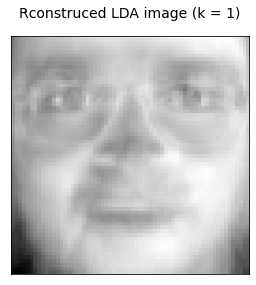

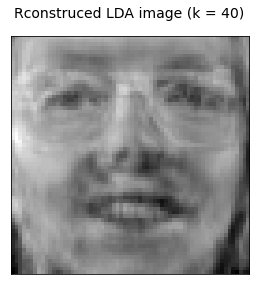

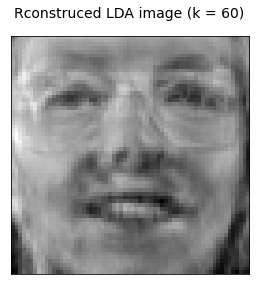

In [4]:
diffrent_k = [1, 40, 60]
for k in diffrent_k:
    lda.transform(k)
    lda.reconstruct(k)
    lda.visualize_single_sample(lda.reconstructed_samples[69], f'Rconstruced LDA image (k = {k})')

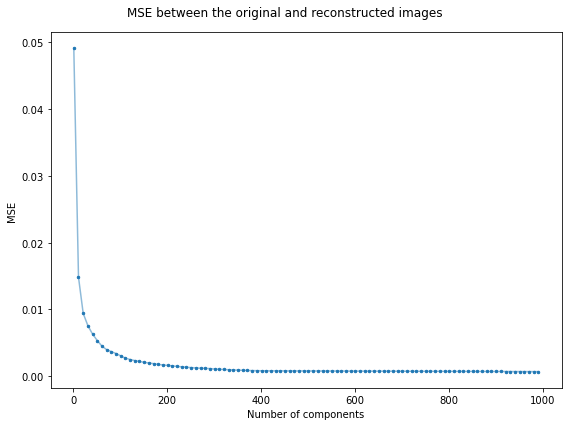

In [5]:
def mean_squared_error(y_true, y_pred):
    return np.mean(np.mean((y_true-y_pred)**2, axis=1))

eigenvectors_num = 1000
step_size = 10
fig, ax = plt.subplots(figsize=(8, 6))
errors = []
for k in range(1, eigenvectors_num, step_size):
    lda.transform(k)
    lda.reconstruct(k)
    errors.append(mean_squared_error(lda.samples, lda.reconstructed_samples))
ax.scatter(range(1, eigenvectors_num, step_size), errors, s=6)
ax.plot(range(1, eigenvectors_num, step_size), errors, alpha=0.5)
ax.set_xlabel('Number of components')
ax.set_ylabel('MSE')
fig.suptitle('MSE between the original and reconstructed images')
plt.tight_layout()
plt.show()